In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10, MNIST
from torch.utils.data.dataloader import DataLoader
from torchvision import transforms
import tensorflow.keras as keras
import os
import sys
import time


PATH = "/content/drive/MyDrive/ColabNotebooks_Nov22/"
# NOTE: Update MODEL according to the model
MODEL = "ResNet-18"
to_string = {MNIST: "MNIST", CIFAR10: "CIFAR-10"}


class Dataset:
    def __init__(self, model, data):
        """
        model: pre-trained ResNet model
        data: CIFAR10 or MNIST
        """
        self.model = model
        self.data = data
        self.num_classes = 10

        transform = transforms.Compose([
            #transforms.Resize(256),
            #transforms.RandomCrop(224),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(
                (0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)
                #(0.5, 0.5, 0.5), (0.25, 0.25, 0.25)
            )
        ]) if self.data is CIFAR10 else transforms.Compose([
            transforms.ToTensor()
        ])
        test_dataset = self.data(
            root="data/", train=False, transform=transform, download=True
        )
        self.test_loader = DataLoader(test_dataset, 
                                      128, 
                                      num_workers=0, 
                                      pin_memory=True)

        # manual normalization
        # mean = [0.5, 0.5, 0.5]
        # std = [0.25, 0.25, 0.25]
        if self.data is CIFAR10:
            (train_x, train_y), (test_x, test_y) = (keras
                                                    .datasets
                                                    .cifar10
                                                    .load_data())
            mean = [0.4914, 0.4822, 0.4465]
            std = [0.2471, 0.2435, 0.2616]
        else:
            (train_x, train_y), (test_x, test_y) = (keras
                                                    .datasets
                                                    .mnist
                                                    .load_data())
            mean = 0
            std = 1

        train_x = train_x / 255.0
        test_x = test_x / 255.0
        test_x = (test_x - mean) / std
        self.test_x = test_x
        self.test_y = test_y
        print("current version: 27-5")
        print(f"training set size = {train_x.shape[0]}, test set size = {test_x.shape[0]}")


    def accuracy_pytorch(self):
        start_time = time.time()
        correct = 0
        total = 0
        # since we're not training, we don't need to calculate the gradients 
        # for our outputs
        with torch.no_grad():
            for data in self.test_loader:
                images, labels = data
                # calculate outputs by running images through the network
                outputs = self.model(images)
                # the class with the highest energy is what we choose as 
                # prediction
                _, predicted = torch.max(outputs[0] if isinstance(outputs,
                    tuple) else outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        print(f"accuracy_pytorch function completed. \nTime: {time.time() - start_time:.6f} seconds")
        return correct / total

    def accuracy(self):
        start_time = time.time()
        n = self.test_x.shape[0]
        accuracy = self.determine_accuracy(np.arange(n)) / n
        print(f"accuracy function completed. \nTime: {time.time() - start_time:.6f} seconds")

        return accuracy

    # Berrut Encoder
    def encoder(self, X, N):
        if self.data is CIFAR10:
            [K, H, W, C] = np.shape(X)
        else:
            [K, H, W] = np.shape(X)
        alpha = np.zeros(K)
        for j in range(K):
            alpha[j] = np.cos(((2*j+1)*np.pi) / (2*K))
        all_z = np.zeros(N)
        for i in range(N):
            all_z[i] = np.cos((i*np.pi) / N)
        coded_X = (np.zeros([N, H, W, C]) if self.data is CIFAR10 else
                np.zeros([N, H, W]))
        for n in range(N):
            z = all_z[n]
            den = 0
            for j in range(K):
                den = den + np.power(-1, j) / (z - alpha[j])
            for i in range(K):
                coded_X[n,] = (coded_X[n,] 
                               + ((np.power(-1, i)/(z-alpha[i]))/den)*X[i,])
        return coded_X

    # Returns the error locations
    def welch_decoder(self, y, K, N, retuned_points_indices):  
        e_max = int((N - 2 * K) / 2)
        e = e_max
        alpha = np.zeros(K)
        for j in range(K):
            alpha[j] = np.cos(((2 * j + 1) * np.pi) / (2 * K))

        all_z = np.zeros(N)
        for i in range(N):
            all_z[i] = np.cos((i * np.pi) / N)

        returned_z=all_z[retuned_points_indices]

        A1 = np.vander(returned_z, N=K + e)
        A2 = np.vander(returned_z, N=K + e )
        A2 = -A2[:, 0:K + e-1]
        A2 = A2 * y
        A = np.concatenate([A1, A2], axis=1)
        A_psudo_inv = np.linalg.pinv(A)
        coeffs = np.matmul(A_psudo_inv, y)

        a = coeffs[0:K + e, 0]
        b = coeffs[K + e:2 * (K + e)-1, 0]
        b = np.reshape(b, [len(b), 1])
        bb = np.concatenate([b, np.ones([1, 1])])
        qlambda_evals = np.zeros([N, 1])

        output = np.zeros([N, 1])
        for i in range(N):
            qlambda_evals[i] = np.polyval(bb, all_z[i])

        idx = np.argpartition(np.abs(qlambda_evals.transpose()), e)
        output = (np.sort(idx[:, :e]))

        return np.sort(idx[:, :e])

    # Berrut Decoder
    def decoder(self, Y, K, N, indices, sigma):

        # when E > 0 
        if indices.size != K:
            e = int((N - 2*K)/2)
            if (N, self.num_classes) != np.shape(Y):
                raise Exception("Shape of Y not matched")
            error_indices = np.random.permutation(indices)[:e]
            # print("true error loc: ", np.sort(error_indices))
            Y[error_indices, :]=Y[error_indices,:]+np.random.normal(0,sigma,[e,self.num_classes])
            adversary_indices_matrix=np.zeros([e, self.num_classes])
            for i in range(self.num_classes):
                y=Y[indices,i]
                y=np.reshape(y,[len(y),1])
                adversary_indices_matrix[:,i]=self.welch_decoder(y,K,N,indices)


            flattened_adversary_indices= adversary_indices_matrix.flatten()
            flattened_adversary_indices=np.reshape(flattened_adversary_indices,[1,len(flattened_adversary_indices)])
            bin_count=(np.bincount(flattened_adversary_indices[0,:].astype(np.int64)))
            temp=((np.argsort(bin_count)))
            error_locations_predicted=temp[-e:]
            # print("predicted error loc: ", np.sort(error_locations_predicted))
            
            for i in range(len(error_locations_predicted)):
                loc=np.where(indices == error_locations_predicted[i])
                indices=np.delete(indices,loc)


        F = len(indices)
        alpha = np.zeros(K)
        for j in range(K):
            alpha[j] = np.cos(((2*j+1)*np.pi) / (2*K))

        z_bar = np.zeros(N)
        for i in range(N):
            z_bar[i] = np.cos((i*np.pi) / N)

        probs = np.zeros([K, self.num_classes])
        for digit in range(self.num_classes):
            for i in range(K):
                z = alpha[i]
                den = 0
                for j in range(F):
                    den = den + np.power(-1, j) / (z - z_bar[indices[j]])
                for l in range(F):
                    probs[i, digit] = probs[i, digit] + ((((np.power(-1, l))
                        / (z - z_bar[indices[l]])) / den) * Y[indices[l],
                            digit])

        return probs

    def outputs(self, Y):
        n = len(Y)
        outputs = np.zeros([n, self.num_classes])
        for i in range(n):
            data = Y[i,]
            torch_sample = torch.from_numpy(data).float()
            torch_sample = (torch_sample.permute(2, 0, 1) if self.data is
                    CIFAR10 else torch_sample.unsqueeze(0))
            torch_sample = torch_sample.unsqueeze(0)
            output = self.model(torch_sample)
            outputs[i,] = ((output[0] if isinstance(output, tuple) else
                output).detach().numpy()[0])

        return outputs

    def determine_accuracy(self, input_batch_ids):
        input_batch = self.test_x[input_batch_ids]
        n = len(input_batch)
        predictions = np.zeros([n, 1])
        for i in range(n):
            data = input_batch[i,]
            torch_sample = torch.from_numpy(data).float()
            torch_sample = (torch_sample.permute(2, 0, 1) if self.data is
                    CIFAR10 else torch_sample.unsqueeze(0))
            torch_sample = torch_sample.unsqueeze(0)
            pred = self.model(torch_sample)
            _, predicts = (torch.max(pred[0] if isinstance(pred, tuple) else
                pred, 1))
            predictions[i] = predicts.numpy()[0]

        temp = self.test_y[input_batch_ids]
        if self.data is MNIST:
            temp = np.reshape(temp, [n, 1])
        diff = temp - predictions
        return n - np.count_nonzero(diff)

    def accuracy_comparison(self, K, N, S, iterations, sigma=0.0):
        start_time = time.time()
        berrut_acc = 0
        center_acc = 0
        print(f"num of iterations = {iterations}, noise sigma = {sigma}")
        for i in range(iterations):
            # Random data
            shuffled_indices = np.random.permutation(self.test_x.shape[0])
            random_indices = shuffled_indices[0:K]
            random_indices = np.sort(random_indices)
            test_sample_x = self.test_x[random_indices]

            single_center_acc = self.determine_accuracy(random_indices)
            center_acc += single_center_acc / K
            
            # Distributed Inference
            # encoding test data
            coded_test_sample_x = self.encoder(test_sample_x, N)
            outputs = self.outputs(coded_test_sample_x)

            # Determining stragglers' indices
            stragglers = np.random.permutation(N)
            stragglers = stragglers[0:N - S]
            stragglers = np.sort(stragglers)
            test_sample_out = self.decoder(outputs, K, N, stragglers, sigma)

            # Perfomance Evaluation
            true_labels = self.test_y[random_indices]
            true_labels = np.reshape(true_labels, [len(true_labels), 1])
            berrut_preds = np.argmax(test_sample_out, axis=1)
            berrut_preds = berrut_preds.reshape(K, 1)
            berrut_acc = (berrut_acc + np.count_nonzero(berrut_preds
                - true_labels) / K)
            if i is 0:
                print(f"Prediction time for batch size {K}: "
                        f"{time.time() - start_time:.6f} seconds")
            print(f"\r{(i+1)*100 // iterations}% completed", end="... " if
                    i + 1 < iterations else "")
        
        print()
        print(f"Time: {time.time() - start_time:.6f} seconds")

        return 1 - berrut_acc/iterations, center_acc / iterations

    # Plot vs K
    def plot_K(self, S=1, K_list=8, e_max=0, noise_sigma = 10.0):

        if isinstance(K_list, int):
            K_list = [K_list]

        berrut_acc = np.zeros(len(K_list))
        center_acc = np.zeros(len(K_list))

        iterations = 100 if self.data is CIFAR10 else 300
        # iterations = 10 # for debug
        print("number of iterations = ", iterations)


        for i, K in enumerate(K_list):
            if e_max == 0:
                print(f"K = {K}")
                berrut_acc[i], center_acc[i] = \
                        self.accuracy_comparison(K, K + S, S, iterations) 
            else:
                print(f"K = {K}, E = {e_max}")
                berrut_acc[i], center_acc[i] = \
                        self.accuracy_comparison(K, 2* K + S + 2*e_max, S, iterations, sigma = noise_sigma)
        path = f"{PATH}/{MODEL}/{to_string[self.data]}/S_only/{S}/"
        if not os.path.exists(path):
            os.makedirs(path)
        os.chdir(path)

        with open(f"output.txt", "w") as f:
            f.write(f"N = K + 1, S = {S}, iterations = {iterations}\n")
            f.write(f"K = {K_list}\n")
            f.write(f"Berrut Accuracy = {berrut_acc}\n")
            f.write(f"Centralized Accuracy = {center_acc}")

        bar_width = 0.2
        X_axis = np.arange(len(K_list))
        plt.xticks(X_axis, K_list)

        plt.bar(X_axis - bar_width, berrut_acc, width=bar_width, 
                label="Berrut")
        for i, v in enumerate(berrut_acc):
            plt.text(X_axis[i] - bar_width, v, f"{v:.2f}")

        plt.bar(X_axis + bar_width, center_acc, width=bar_width, 
                label="Centralized")
        for i, v in enumerate(center_acc):
            plt.text(X_axis[i] + bar_width, v, f"{v:.2f}")

        plt.legend(["Berrut", "Centralized"])
        plt.xlabel("K")
        plt.ylabel("Accuracy")
        plt.title(f"{to_string[self.data]} accuracy for K = {K_list} " 
                  f"and S = {S} ({iterations} iterations)")
        plt.savefig(f"{S}.png")
        plt.show()


    # Plot vs E
    def plot_E(self, S=0, K=8, E_list=1, noise_sigma = 10.0):

        if isinstance(E_list, int):
            E_list = [E_list]
        if not isinstance(K, int):
            raise Exception("K should contain only one integer")
            
        berrut_acc = np.zeros(len(E_list))
        center_acc = np.zeros(len(E_list))

        iterations = 200 if self.data is CIFAR10 else 300
        # iterations = 10 # for debug
        print("number of iterations = ", iterations)


        for i, e_max in enumerate(E_list):
            if e_max == 0:
                print(f"K = {K}")
                berrut_acc[i], center_acc[i] = \
                        self.accuracy_comparison(K, K + S, S, iterations) 
            else:
                print(f"K = {K}, E = {e_max}")
                berrut_acc[i], center_acc[i] = \
                        self.accuracy_comparison(K, 2* K + S + 2*e_max, S, iterations, sigma = noise_sigma)
        path = f"{PATH}/{MODEL}/{to_string[self.data]}/E_only/sigma_{int(noise_sigma)}/K_{K}/"
        if not os.path.exists(path):
            os.makedirs(path)
        os.chdir(path)

        with open(f"output.txt", "w") as f:
            f.write(f"N = 2* K + S + 2*E, S = {S}, iterations = {iterations}\n")
            f.write(f"E = {E_list}\n")
            f.write(f"$\sigma$ = {noise_sigma}\n")
            f.write(f"Berrut Accuracy = {berrut_acc}\n")
            f.write(f"Centralized Accuracy = {np.mean(center_acc)}")

        bar_width = 0.2
        X_axis = np.arange(len(E_list))
        plt.xticks(X_axis, E_list)

        plt.bar(X_axis - bar_width, berrut_acc, width=bar_width, 
                label="Berrut")
        for i, v in enumerate(berrut_acc):
            plt.text(X_axis[i] - bar_width, v, f"{v:.2f}")

        plt.bar(X_axis + bar_width, center_acc, width=bar_width, 
                label="Centralized")
        for i, v in enumerate(center_acc):
            plt.text(X_axis[i] + bar_width, v, f"{v:.2f}")

        plt.legend(["Berrut", "Centralized"])
        plt.xlabel("E")
        plt.ylabel("Accuracy")
        plt.title(f"{to_string[self.data]} accuracy ({iterations} iterations) \n"
            f"K = {K}, S = {S} and E = {E_list}, $\sigma$ = {noise_sigma}\n")
        plt.savefig(f"{K}.png")
        plt.show()

## Load 


In [ ]:
#  Colab only
from google.colab import drive
%matplotlib inline

drive.mount("/content/drive")

Mounted at /content/drive


# Base Imports

In [ ]:
import sys
import torch
from torchvision.datasets import CIFAR10, MNIST

PATH = "/content/drive/MyDrive/ColabNotebooks_Nov22/"
sys.path.append(PATH)

In [ ]:
import dataset_byzantine

modulename = 'dataset_byzantine'
if modulename not in sys.modules:
    print('You have not imported the {} module'.format(modulename))
dataset_byzantine.MODEL = "ResNet-18"
# Dataset.MODEL = "ResNet-18"

# DATA = MNIST
DATA = CIFAR10

## Model

In [ ]:
if DATA is CIFAR10:
    import cifar10_models_resnet as resnet
    model = resnet.resnet18(pretrained=True)
else:
    import resnet18 as resnet
    model = resnet.ResNet18(size_for_cifar=False)
    model.load_state_dict(torch.load(PATH + "mnist_resnet18_model.t7"))

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Model Accuracy

In [ ]:
#### Import data from Keras
import tensorflow.keras as keras
from dataset_byzantine import Dataset


ds = Dataset(model, DATA)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/
170498071/170498071 [==============================] - 2s 0us/step
current version: 27-5
training set size = 50000, test set size = 10000


In [ ]:
print("Accuracy of the network on test images:", 
      ds.accuracy_pytorch())

accuracy_pytorch function completed. 
Time: 126.306651 seconds
Accuracy of the network on test images: 0.993


In [ ]:
print(f"Model accuracy:", ds.accuracy())

accuracy function completed. 
Time: 0.000007 seconds
Model accuracy: 0.9307


## Basic test


number of iterations =  100
K = 8
num of iterations = 100, noise sigma = 0.0
Prediction time for batch size 8: 0.431873 seconds
100% completed
Time: 30.943385 seconds


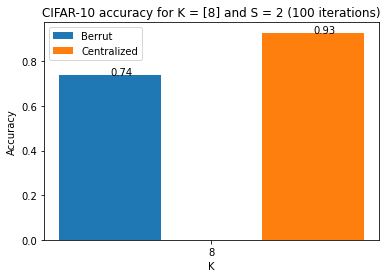

In [ ]:
ds.plot_K(S=2)

number of iterations =  10
K = 8, E = 1
num of iterations = 10, noise sigma = 1.0
Prediction time for batch size 8: 0.430689 seconds
100% completed
Time: 4.058044 seconds


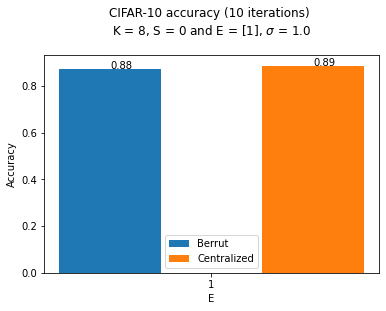

In [ ]:
ds.plot_E(S=0, K = 8, E_list=[1], noise_sigma= 1.0)

## K =12, S = 0, E = [1,2,3] 

number of iterations =  200
K = 12, E = 1
num of iterations = 200, noise sigma = 1.0
Prediction time for batch size 12: 0.605085 seconds
100% completed
Time: 121.601515 seconds
K = 12, E = 2
num of iterations = 200, noise sigma = 1.0
Prediction time for batch size 12: 0.625307 seconds
100% completed
Time: 126.515660 seconds
K = 12, E = 3
num of iterations = 200, noise sigma = 1.0
Prediction time for batch size 12: 0.657348 seconds
100% completed
Time: 132.396314 seconds


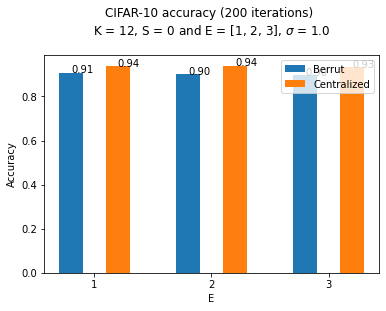

number of iterations =  200
K = 12, E = 1
num of iterations = 200, noise sigma = 10.0
Prediction time for batch size 12: 0.607650 seconds
100% completed
Time: 124.605494 seconds
K = 12, E = 2
num of iterations = 200, noise sigma = 10.0
Prediction time for batch size 12: 0.640402 seconds
100% completed
Time: 126.571548 seconds
K = 12, E = 3
num of iterations = 200, noise sigma = 10.0
Prediction time for batch size 12: 0.645748 seconds
100% completed
Time: 134.295053 seconds


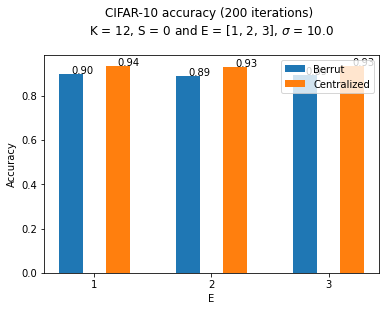

number of iterations =  200
K = 12, E = 1
num of iterations = 200, noise sigma = 100.0
Prediction time for batch size 12: 0.634884 seconds
100% completed
Time: 122.338164 seconds
K = 12, E = 2
num of iterations = 200, noise sigma = 100.0
Prediction time for batch size 12: 0.643297 seconds
100% completed
Time: 127.854419 seconds
K = 12, E = 3
num of iterations = 200, noise sigma = 100.0
Prediction time for batch size 12: 0.674559 seconds
100% completed
Time: 135.280403 seconds


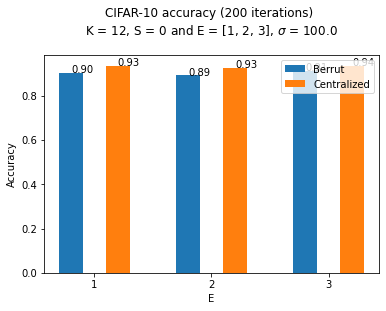

In [ ]:
for sigma in [1.0, 10.0, 100.0]:
    ds.plot_E(S=0, K = 12, E_list=[1,2,3], noise_sigma= sigma)
    

# ds.plot_E(S=0, K = 12, E_list=[1,2,3], noise_sigma= 1.0)
# ds.plot_E(S=0, K = 12, E_list=[1,2,3], noise_sigma= 10.0)
# ds.plot_E(S=0, K = 12, E_list=[1,2,3], noise_sigma= 100.0)

In [ ]:
ds.plot_E(S=0, K = 12, E_list=[1,2,3], noise_sigma= 1.0)

In [ ]:
ds.plot_E(S=0, K = 12, E_list=[1,2,3], noise_sigma= 10.0)

In [ ]:
ds.plot_E(S=0, K = 12, E_list=[1,2,3], noise_sigma= 100.0)

## K =12, S = 0, E = 1, 2, 3 seperately

number of iterations =  100
K = 12, E = 1
num of iterations = 100, noise sigma = 1.0
Prediction time for batch size 12: 0.624688 seconds
100% completed
Time: 62.339725 seconds


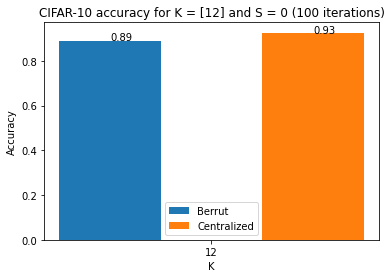

In [ ]:
ds.plot_K(S=0, K_list= 12, e_max=1, noise_sigma= 1.0)

number of iterations =  100
K = 12, E = 2
num of iterations = 100, noise sigma = 1.0
Prediction time for batch size 12: 0.663466 seconds
100% completed
Time: 74.727300 seconds


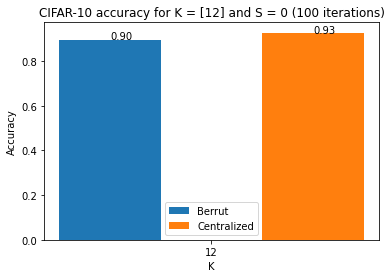

In [ ]:
ds.plot_K(S=0, K_list= 12, e_max=2, noise_sigma= 1.0)

number of iterations =  100
K = 12, E = 3
num of iterations = 100, noise sigma = 1.0
Prediction time for batch size 12: 0.697027 seconds
100% completed
Time: 67.464064 seconds


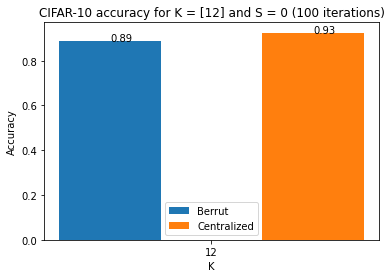

In [ ]:
ds.plot_K(S=0, K_list= 12, e_max=3, noise_sigma= 1.0)

number of iterations =  100
K = 12, E = 1
Prediction time for batch size 12: 0.613797 seconds
100% completed
Time: 60.713815 seconds


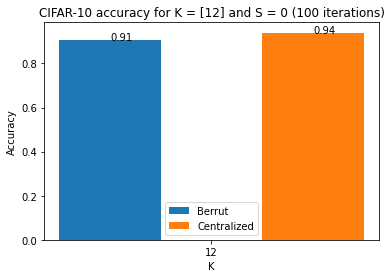

In [ ]:
ds.plot_K(S=0, K_list= 12, e_max=1, noise_sigma= 10.0)

In [ ]:
ds.plot_K(S=0, K_list= 12, e_max=2, noise_sigma= 10.0)

In [ ]:
ds.plot_K(S=0, K_list= 12, e_max=3, noise_sigma= 10.0)

In [ ]:
ds.plot_K(S=0, K_list= 12, e_max=1, noise_sigma= 100.0)

In [ ]:
ds.plot_K(S=0, K_list= 12, e_max=2, noise_sigma= 100.0)

In [ ]:
ds.plot_K(S=0, K_list= 12, e_max=3, noise_sigma= 100.0)